In [305]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import legacy
import matplotlib.pyplot as plt

In [306]:
# Build DataFrame
df = pd.read_csv("./Ethereum Historical Data.csv", thousands=",")
df = df.loc[:, ['Date', 'High', 'Low', 'Open', 'Vol', 'Price']]
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')
df.set_index('Date', inplace=True)

In [307]:
# Parse Volume values from str to float
def parse_volume(value):
    if isinstance(value, str):
        if value == '-':
            return 0.0
        elif value.endswith('K'):
            return float(value.replace('K', '')) * 1e3
        elif value.endswith('M'):
            return float(value.replace('M', '')) * 1e6
        elif value.endswith('B'):
            return float(value.replace('B', '')) * 1e9
        else:
            return float(value)
    return value

df['Vol'] = df['Vol'].apply(parse_volume)

In [308]:
# Define training data and testing data
# Train model with lines of data after the 365th
# Use the first 365 lines of data to examine the output of prediction
train_data = df.iloc[365:]
test_data = df.iloc[:365]

In [309]:
# Normalise data with MinMax for large range variables
aim = 'Price'
scaler = MinMaxScaler(feature_range=(0, 1))
# features_to_scale = df.columns
# df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
# df[aim] = scaler.fit_transform(df[aim].values.reshape(-1, 1))

In [310]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(19, 10))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Ethereum', fontsize=16)
    ax.legend(loc='best', fontsize=16)

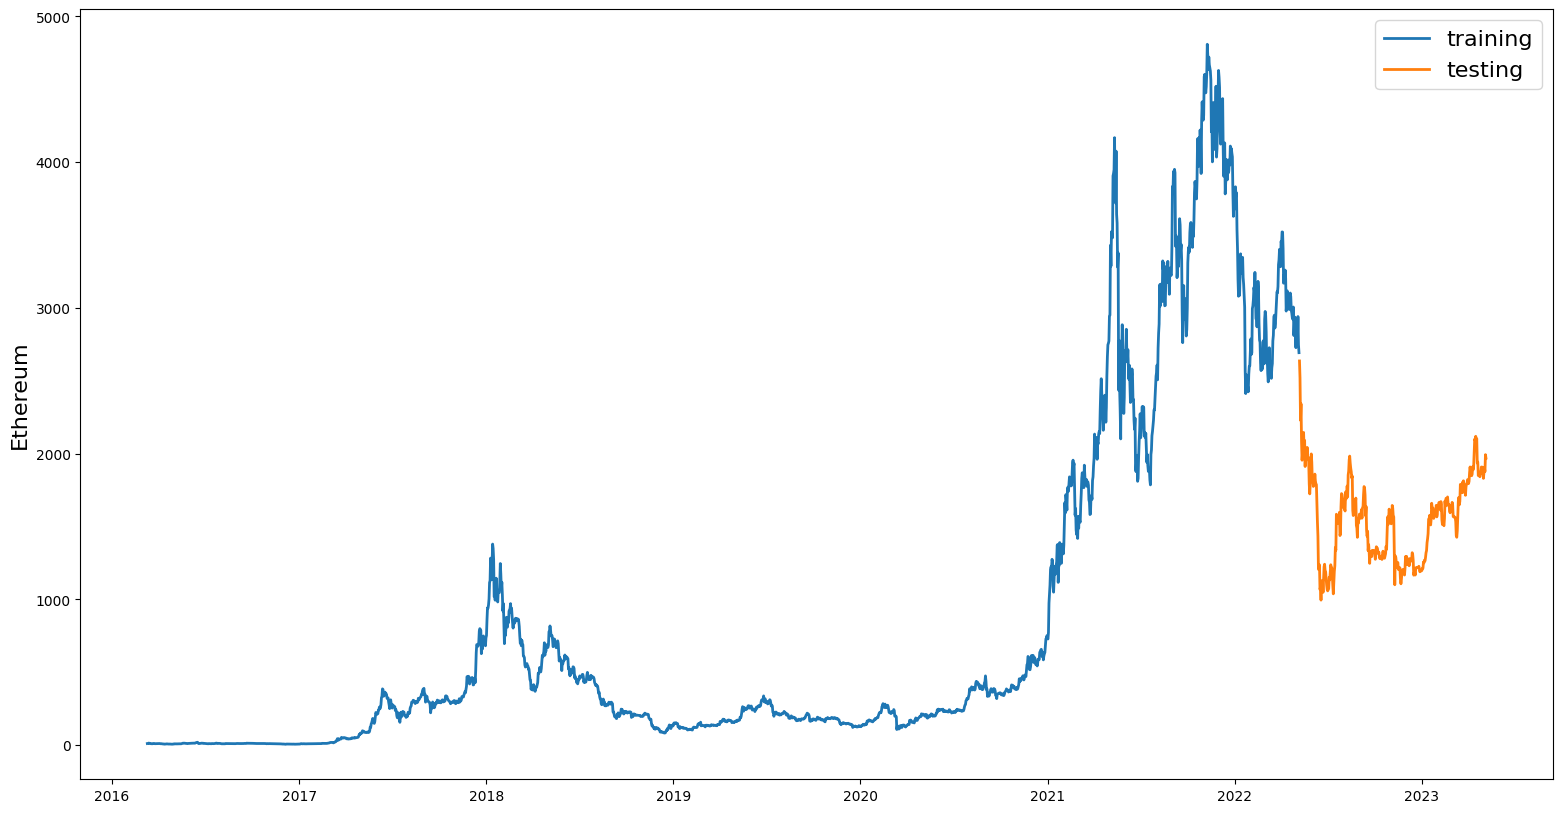

In [311]:
line_plot(train_data[aim], test_data[aim], 'training', 'testing', title='')

In [312]:
# Transform DataFrame into inputs/outputs for LSTM time series forcasting models
def transfom(df, window_size=5, fit=True):
    T = []
    for i in range(len(df)-window_size):
        window = df.iloc[i:i+window_size]
        if fit:
            scaled_window = scaler.fit_transform(window)
        else:
            scaled_window = scaler.transform(window)
        T.append(scaled_window)
    return np.array(T)

In [313]:
# Prepare data
WINDOW_SIZE = 5
X_train = transfom(train_data, WINDOW_SIZE, True)
X_test = transfom(test_data, WINDOW_SIZE, True)
y_train = train_data[aim][WINDOW_SIZE:].values / train_data[aim][:-WINDOW_SIZE].values - 1
y_test = test_data[aim][WINDOW_SIZE:].values / test_data[aim][:-WINDOW_SIZE].values - 1

In [314]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('linear'))
# model.summary()
model.compile(loss='mean_squared_error',
              optimizer=legacy.Adam(learning_rate=0.001))
modelfit = model.fit(X_train, y_train, validation_data=(
    X_test, y_test), epochs=30, batch_size=32, verbose=1, shuffle=True)

Epoch 1/30
71/71 [==============================] - 1s 4ms/step - loss: 0.0106 - val_loss: 0.0047
Epoch 2/30
71/71 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0045
Epoch 3/30
71/71 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0043
Epoch 4/30
71/71 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 5/30
71/71 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0041
Epoch 6/30
71/71 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 7/30
71/71 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 8/30
71/71 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0040
Epoch 9/30
71/71 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0040
Epoch 10/30
71/71 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0041
Epoch 11/30
71/71 [

In [315]:
targets = test_data[aim][WINDOW_SIZE:]
preds = model.predict(X_test).squeeze()

12/12 [==============================] - 0s 684us/step


In [316]:
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, preds)
r2_score*100

63.22604404845966

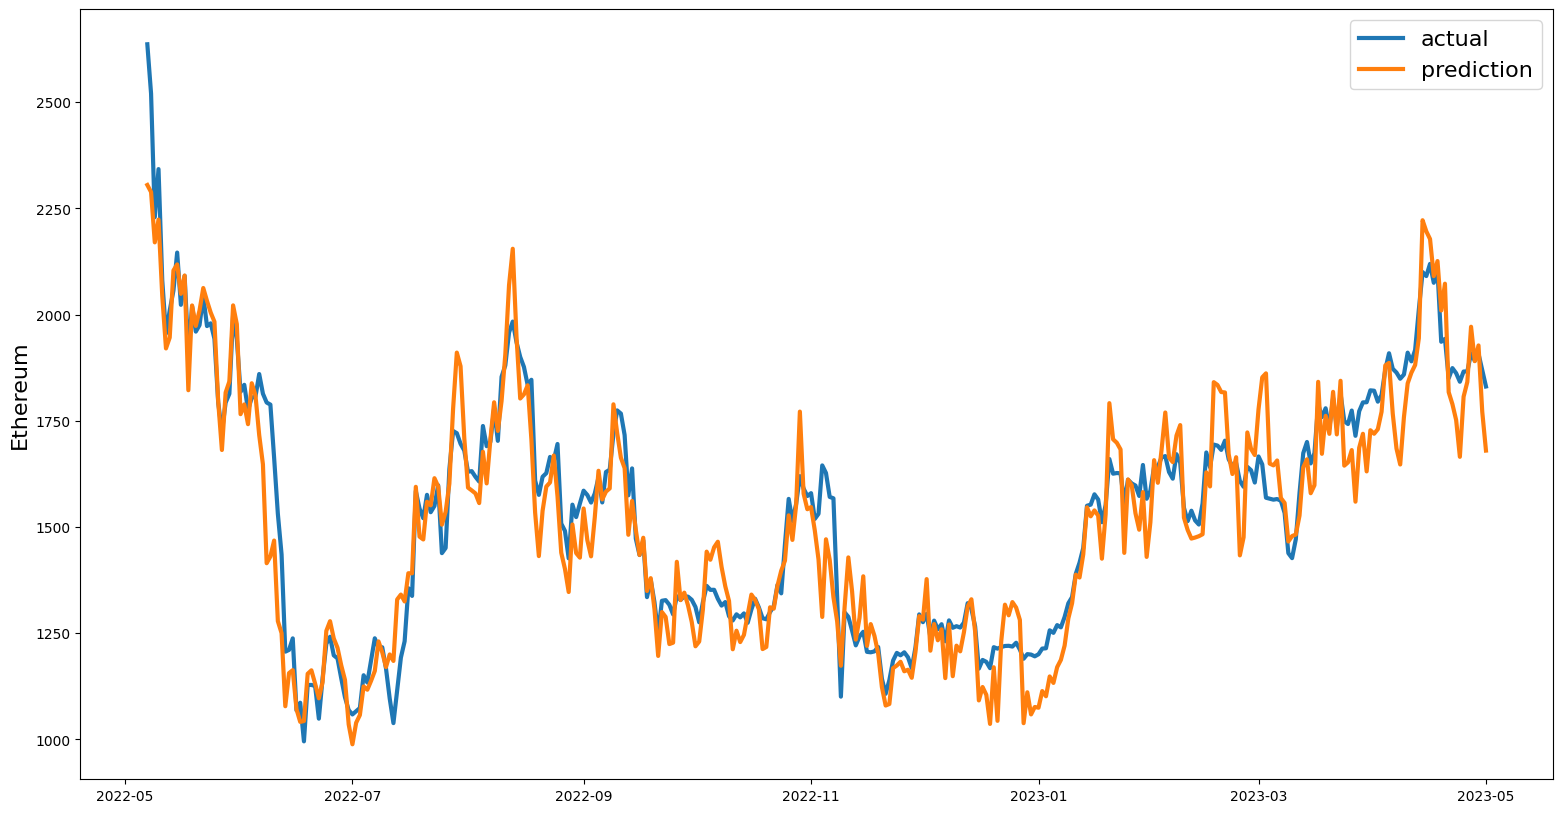

In [317]:
preds = test_data[aim].values[:-WINDOW_SIZE] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)